This algorithem gets a Strava activities csv,

visualizing height, distance, running times etc...

learning the behavior of the runner.

allows for ui calculation of running time using specified height and distance.

(<Figure size 432x288 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f489e3d36d0>)


Text(value='The estimated time is: 4.534374632488723 Hours or 272.0624779493234 Minutes', layout=Layout(height…

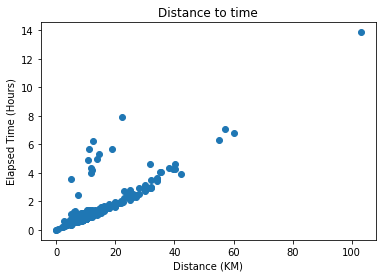

In [ ]:
def main():
  #@title Running time Calculator { run: "auto" }
  #@
  #------------------------------------------------------
  # Load data.
  execfile('load_data.py')
  training_set, cv_set, test_set, complete_set = load_data_from_csv()

  #------------------------------------------------------------------
  # Visualize dataset.
  execfile('visualize_distance.py')
  print(visualize_distance_from_csv(complete_set))

  ##execfile('visualize_elevation_gain.py')
  ##print(visualize_elevation_gain_from_csv(complete_set))

  ##execfile('visualize_elevation_loss.py')
  ##print(visualize_elevation_loss_from_csv(complete_set))

  #-----------------------------------------------------------------
  # Calculate OLS models and choose.
  execfile('Calculate_models.py')
  ##model_calculation(training_set, cv_set, "ols")
  ##model_calculation(training_set, cv_set, "RecursiveLS")

  #-----------------------------------------------------------------
  # I get very similar results. Need to break up the comparison.
  ##model_calculation(training_set, test_set, "ols")
  ##model_calculation(training_set, test_set, "RecursiveLS")

  #----------------------------------------------------------------
  # Get the chosen model's detailes.
  execfile('ols_model.py')
  execfile('wls_model.py')
  completeSummary, mainRValue, model = calc_cost_of_run(complete_set)

  Distance =  42#@param {type:"number"}
  ##Elevation_Gain =   0.05#@param {type:"number"}
  ##predict_data = [[Distance, Elevation_Gain]]
  predict_data = [[Distance]]

  ##predict_data_df = pd.DataFrame(predict_data, columns = ['Distance', 'Elevation Gain'])
  predict_data_df = pd.DataFrame(predict_data, columns = ['Distance'])
  prediction = model.predict(predict_data_df)[0]
  prediction_min = prediction * 60
  output_text = widgets.Text(layout=widgets.Layout(width='600px', height='80px'))
  output_text.value = "The estimated time is: " + str(prediction) + " Hours or " + str(prediction_min) +" Minutes"
  display(output_text)
  
    


if __name__ == "__main__":
    main()

In [ ]:
#@title Load Modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import ipywidgets as widgets
from IPython.display import display

In [ ]:
#@title Load Data
%%writefile load_data.py
def load_data_from_csv():
  
  # Load plain data
  user_csv = pd.read_csv("/content/drive/MyDrive/activities.csv")

  # Clean data
  ##cleaned_user_csv = user_csv.loc[:, ('Distance', 'Elevation Gain', 'Elapsed Time')]
  cleaned_user_csv = user_csv.loc[:, ('Distance', 'Elapsed Time')]

  # Adjust unit of measurment to Km/H
  ##cleaned_user_csv['Elevation Gain'] /= 1000
  cleaned_user_csv['Elapsed Time'] /= 3600 

  cleaned_user_csv = cleaned_user_csv.dropna()

  # Split the csv to training, cv and test set
  training_set = cleaned_user_csv[:243]
  cv_set = cleaned_user_csv[243:361]
  test_set = cleaned_user_csv[361:]

  return training_set, cv_set, test_set, cleaned_user_csv

Overwriting load_data.py


In [ ]:
#@title Visualize Distance
%%writefile visualize_distance.py
def visualize_distance_from_csv(cleaned_user_csv):
  # create a figure and axis
  fig, ax = plt.subplots()

  # scatter the distance against the Elapsed Time of the run.
  ax.scatter(cleaned_user_csv['Distance'], cleaned_user_csv['Elapsed Time'])

  # set a title and labels
  ax.set_title('Distance to time')
  ax.set_xlabel('Distance (KM)')
  ax.set_ylabel('Elapsed Time (Hours)') 
  return fig, ax

Overwriting visualize_distance.py


In [ ]:
#@title visualize Elevation Gain
%%writefile visualize_elevation_gain.py
def visualize_elevation_gain_from_csv(cleaned_user_csv):
  # create a figure and axis
  fig, ax = plt.subplots()

  # scatter the distance against the Elapsed Time of the run.
  ax.scatter(cleaned_user_csv['Elevation Gain'], cleaned_user_csv['Distance'])

  # set a title and labels
  ax.set_title('Elevation Gain to time')
  ax.set_xlabel('Elevation Gain (KM)')
  ax.set_ylabel('Distance (KM)') 
  return fig, ax

Overwriting visualize_elevation_gain.py


In [ ]:
#@title OLS model
%%writefile ols_model.py
def calc_cost_of_run(cleaned_user_csv):
  X = sm.hasconst
  ##X = cleaned_user_csv.loc[:, ('Distance', 'Elevation Gain')]
  X = cleaned_user_csv.loc[:, ('Distance')]
  Y = cleaned_user_csv.loc[:, ('Elapsed Time')]
  # Build a model that calculates the cost and predict it.
  model = sm.OLS(Y, X).fit()
  return model.summary(), model.rsquared, model

Overwriting ols_model.py


In [ ]:
#@title WLS model
%%writefile wls_model.py
def calc_weighted_cost_of_run(cleaned_user_csv):
  X = cleaned_user_csv.loc[:, ('Distance', 'Elevation Gain')]
  X = sm.add_constant(X)
  weights = X.copy()
  weights = weights / weights
  weights['Distance'] = weights['Distance'].apply(lambda x: x*5)
  Y = cleaned_user_csv.loc[:, ('Elapsed Time')]

  # Build a model that calculates the cost and predict it.

  model = sm.WLS(Y, X, weights)
  model = model.fit()
  return model.summary(), model.rsquared, model

Overwriting wls_model.py


In [ ]:
#@title Recursive model
%%writefile Recursive_model.py
def calc_recursive_cost(cleaned_user_csv):
  X = cleaned_user_csv.loc[:, ('Distance', 'Elevation Gain')]
  X = sm.add_constant(X)
  Y = cleaned_user_csv.loc[:, ('Elapsed Time')]

  # Build a model that calculates the cost and predict it.
  model = sm.RecursiveLS(Y, X).fit()
  return model.summary(), model.rsquared, model

Overwriting Recursive_model.py


In [ ]:
#@title Calculate models
%%writefile Calculate_models.py
def model_calculation(training_set, cv_set, model):
  execfile('ols_model.py')
  execfile('Recursive_model.py')
  if model == 'ols':
    print("ols results:")

    # Calculate model on training set
    trainSummary, mainRValue, model = calc_cost_of_run(training_set)
    print("")
    print("The summary of OLS fitting First set is:")
    print(trainSummary)
    print("")
    print("the R Value is: ")
    print(mainRValue)

    # Run model on cv_set
    cvSummary, cvRValue, model = calc_cost_of_run(cv_set)
    print("")
    print("The summary of OLS fitting Second set is:")
    print(cvSummary)
    print("")
    print("the R Value is: ")
    print(cvRValue)

  elif model == 'RecursiveLS':
    print("RLS results:")
    trainSummary_recursive, mainRValue_recursive, model = calc_recursive_cost(training_set)
    print("")
    print("The summary of RLS fitting First set is:")
    print(trainSummary_recursive)
    print("")
    print("the R Value is: ")
    print(mainRValue_recursive)

    # Run model on cv_set
    cvSummary_recursive, cvRValue_recursive, model = calc_recursive_cost(cv_set)
    print("")
    print("The summary of RLS fitting Second set is:")
    print(cvSummary_recursive)
    print("")
    print("the R Value is: ")
    print(cvRValue_recursive)


Overwriting Calculate_models.py
